In [1]:
from PIL import Image, ImageChops, ImageEnhance
import sys, os.path
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
#np.set_printoptions(threshold=10)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import utils

np.random.seed(2)
tf.random.set_seed(2)

In [2]:
image_path_ela="D:/Casia/CASIA2/Ela"
image_path_resaved="D:/Casia/CASIA2/Ela/resaved"


def ela(filename):
    file_name = filename.split("\\")[-1]
    resaved = f"{image_path_resaved}/{file_name}" + '.resaved.jpg'
    ela = f"{image_path_ela}/{file_name}"  + '.ela.png'
    im = Image.open(filename).convert('RGB')

    im.save(resaved, 'JPEG', quality=95)
    resaved_im = Image.open(resaved)

    ela_im = ImageChops.difference(im, resaved_im)
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0/max_diff

    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)

    ela_im.save(ela)
    return ela_im

In [3]:
def convert_image_to_array(image_path):
    size=(128,128)
    return np.array(ela(image_path).resize(size)).flatten() / 255.0

In [5]:
X=[]
Y=[]

In [6]:
tp_path="D:\Casia\CASIA2\Tp\\"
au_path="D:\Casia\CASIA2\Au\\"

In [7]:
#authentic (1)
for filename in tqdm(os.listdir(au_path), desc='processing images'):
    if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
        f = os.path.join(au_path, filename)
        X.append(convert_image_to_array(f))
        Y.append(1)

        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

#tp (0)
for filename in tqdm(os.listdir(tp_path), desc='processing images'):
    if filename.endswith('jpg') or filename.endswith('png') or filename.endswith('tif'):
        f = os.path.join(tp_path, filename)
        X.append(convert_image_to_array(f))
        Y.append(0)

        
print(f'Total images: {len(X)}\nTotal labels: {len(Y)}')

processing images:   0%|          | 0/7493 [00:00<?, ?it/s]

Total images: 7354
Total labels: 7354


processing images:   0%|          | 0/5124 [00:00<?, ?it/s]

Total images: 12477
Total labels: 12477


In [8]:
X=np.array(X)
Y=np.array(Y)
X = X.reshape(-1, 128, 128, 3)
print(X.shape)
print(Y.shape)

(12477, 128, 128, 3)
(12477,)


In [9]:
x_train, x_, y_train, y_ = train_test_split(X, Y, test_size=0.20, random_state=1)

x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

del x_, y_

X=X.reshape(-1,1,1,1)

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (9981, 128, 128, 3)
the shape of the training set (target) is: (9981,)

the shape of the cross validation set (input) is: (1248, 128, 128, 3)
the shape of the cross validation set (target) is: (1248,)

the shape of the test set (input) is: (1248, 128, 128, 3)
the shape of the test set (target) is: (1248,)


In [ ]:
model = Sequential([
    layers.Conv2D(32, 5, padding='same', activation='relu', input_shape = (128,128,3)),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid', name="outputs")
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(f"training {model.name}...")

early_stopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')
epochs=5
history = model.fit(
    x_train, y_train,
    validation_data=(x_cv, y_cv),
    epochs=epochs,
    batch_size=32,
    callbacks=[early_stopping]
)


In [ ]:
epochs=1
history = model.fit(
    x_train, y_train,
    validation_data=(x_cv, y_cv),
    epochs=epochs,
    batch_size=32,
    callbacks=[early_stopping]
)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
print(x_test.shape)

In [ ]:
yhat=model.predict(x_test)

In [ ]:
yhat_r = np.round(yhat)
test_error = np.mean(yhat_r != y_test)

In [ ]:
correct = 0 #correctly predicted test images
total = 0   #total test images

for index,image in enumerate(tqdm(x_test,desc="Processing Images : ")):
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model.predict(image)
    y_pred_class = np.round(y_pred)
    total += 1
    if y_pred_class == y_test[index]: #if prediction is correct
        correct += 1
        


In [ ]:
print(f'Total test images: {total}\nCorrectly predicted images: {correct}\nAccuracy: {correct / total * 100.0} %')

In [ ]:
model.save('Casia2_Model')

In [28]:
model_1 = Sequential([
    layers.Conv2D(32, 5, padding='same', activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01),input_shape = (128,128,3)),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 5, padding='same', activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid', name="outputs")
])

In [29]:
model_1.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(f"training {model.name}...")

early_stopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')
epochs=20
history = model_1.fit(
    x_train, y_train,
    validation_data=(x_cv, y_cv),
    epochs=epochs,
    batch_size=32,
)


training sequential_2...
Epoch 1/20
312/312 [==============================] - 152s 482ms/step - loss: 0.5562 - accuracy: 0.8240 - val_loss: 0.3551 - val_accuracy: 0.8846
Epoch 2/20
312/312 [==============================] - 150s 480ms/step - loss: 0.3705 - accuracy: 0.8749 - val_loss: 0.3309 - val_accuracy: 0.8878
Epoch 3/20
312/312 [==============================] - 149s 479ms/step - loss: 0.3362 - accuracy: 0.8868 - val_loss: 0.2918 - val_accuracy: 0.9046
Epoch 4/20
312/312 [==============================] - 150s 482ms/step - loss: 0.3085 - accuracy: 0.8918 - val_loss: 0.2919 - val_accuracy: 0.8966
Epoch 5/20
312/312 [==============================] - 151s 484ms/step - loss: 0.2824 - accuracy: 0.9002 - val_loss: 0.2450 - val_accuracy: 0.9175
Epoch 6/20
312/312 [==============================] - 152s 487ms/step - loss: 0.2603 - accuracy: 0.9055 - val_loss: 0.2563 - val_accuracy: 0.9143
Epoch 7/20
312/312 [==============================] - 149s 477ms/step - loss: 0.2393 - accuracy: 0.

In [ ]:
epochs=5
history = model_1.fit(
    x_train, y_train,
    validation_data=(x_cv, y_cv),
    epochs=epochs,
    batch_size=32,
)

In [ ]:
model.save('Casia2_Model_1')

In [13]:
model_2 = Sequential([
    layers.Conv2D(32, 5, padding='same', activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01),input_shape = (128,128,3)),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 5, padding='same', activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 5, padding='same', activation='relu',  kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid', name="outputs")
])

In [14]:
model_2.compile(optimizer=Adam(0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(f"training {model_2.name}...")

early_stopping = EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=5,
                              verbose=0, mode='auto')
epochs=30
history = model_2.fit(
    x_train, y_train,
    validation_data=(x_cv, y_cv),
    epochs=epochs,
    batch_size=32,
)

training sequential_2...
Epoch 1/30
312/312 [==============================] - 158s 502ms/step - loss: 0.5069 - accuracy: 0.8362 - val_loss: 0.4173 - val_accuracy: 0.8438
Epoch 2/30
312/312 [==============================] - 162s 519ms/step - loss: 0.3724 - accuracy: 0.8716 - val_loss: 0.3593 - val_accuracy: 0.8702
Epoch 3/30
312/312 [==============================] - 163s 523ms/step - loss: 0.3550 - accuracy: 0.8771 - val_loss: 0.3312 - val_accuracy: 0.8862
Epoch 4/30
312/312 [==============================] - 156s 501ms/step - loss: 0.3628 - accuracy: 0.8711 - val_loss: 0.3171 - val_accuracy: 0.8958
Epoch 5/30
312/312 [==============================] - 158s 508ms/step - loss: 0.3430 - accuracy: 0.8798 - val_loss: 0.3246 - val_accuracy: 0.8902
Epoch 6/30
312/312 [==============================] - 159s 510ms/step - loss: 0.3323 - accuracy: 0.8833 - val_loss: 0.3595 - val_accuracy: 0.8710
Epoch 7/30
312/312 [==============================] - 175s 561ms/step - loss: 0.3267 - accuracy: 0.

In [15]:
model = tf.keras.models.load_model('Casia2_model')

In [39]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay

In [37]:
def display_conf_matrix(y_true, y_preds):
    cm = confusion_matrix(y_true, y_preds)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Tp','Au'])
    cmd.plot()

In [ ]:
Y_pred = model.predict(x_cv)               
Y_pred_classes = np.round(Y_pred)           
Y_true = y_cv                             

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)    

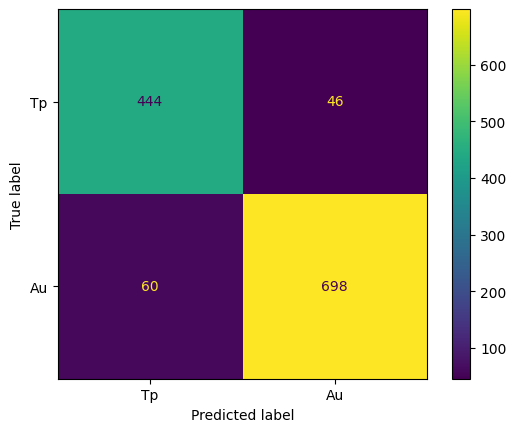

In [41]:
display_conf_matrix(Y_true,Y_pred_sigmoid)  

39/39 [==============================] - 4s 92ms/step


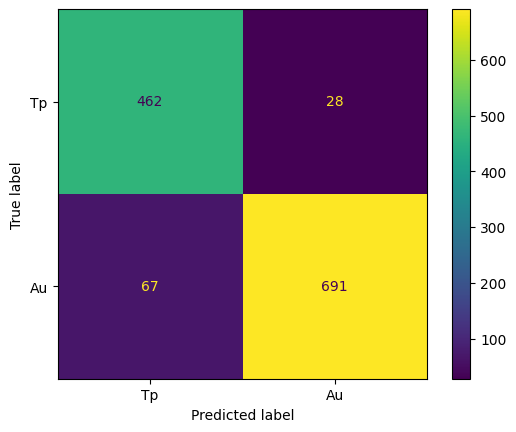

In [42]:
Y_pred_1 = model_1.predict(x_cv)               
Y_pred_sigmoid_1 = np.round(Y_pred_1)           
Y_true = y_cv                              
display_conf_matrix(Y_true,Y_pred_sigmoid_1)  

In [43]:
model_1.save('Casia_Model_1')

INFO:tensorflow:Assets written to: Casia_Model_1\assets


INFO:tensorflow:Assets written to: Casia_Model_1\assets


39/39 [==============================] - 4s 103ms/step


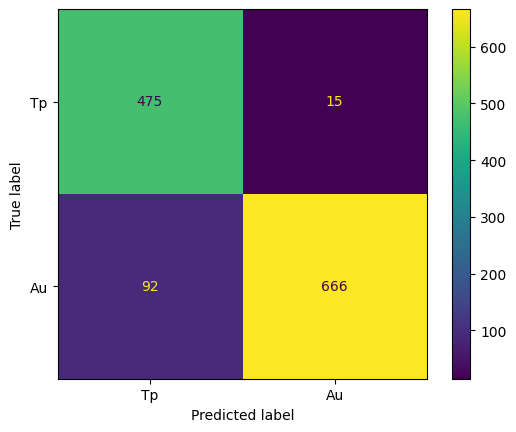

In [44]:
Y_pred_1 = model_2.predict(x_cv)               
Y_pred_sigmoid_1 = np.round(Y_pred_1)           
Y_true = y_cv                              
display_conf_matrix(Y_true,Y_pred_sigmoid_1)  